In [ ]:
## Pytorch Transfer Learning

# Transfer learning involves taking the parameters of what one model has learned on another dataset

# pretrained model = foundation models

In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4028, done.
remote: Counting objects: 100% (1216/1216), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 4028 (delta 1065), reused 1096 (delta 998), pack-reused 2812
Receiving objects: 100% (4028/4028), 651.38 MiB | 39.88 MiB/s, done.
Resolving deltas: 100% (2358/2358), done.
Updating files: 100% (248/248), done.


In [ ]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Sun Oct 15 15:27:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
##Get Data
import os
import zipfile

from pathlib import Path

import requests

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder doesn't exist, downlaod it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / "pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  os.remove(data_path / "pizza_steak_sushi.zip")


Did not find data/pizza_steak_sushi, downloading it...
Unzipping pizza, steak, sushi data...


In [ ]:
# setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# create datasets and dataloaders

# want to turn it into pytorch dataloaders
# to do so, we can use data_Setup.py and create_dataloaders

# there is one thing we have to think about when loading: how to transform it?
# - manually created transforms - you define what transforms you want your data to go through
# - automatically created transforms - the transforms for your data are defined by the model you'd like to use

# important point: when using a pretrained model, it's important that the data
# (including custom data) thtat you pass through it is transformed in the same way that the data the model was trained on

from going_modular.going_modular import data_setup

In [ ]:
##Creating a transform for torchvision.models (manual creation)

# torchvision.models contains pretrained models (models ready for transfer learning) right within torchvision

from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,test_dir,manual_transforms,32)
train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x7e6aca607400>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
## Creating a transform for torchvision.models (auto creation)

# as of torchvision ther is now support for automatic data transform creation based on the pretrained model weights you are using

# get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# get the transforms used to create our pretrained weights

auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
#create dataloaders using automatic transforms

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,test_dir,auto_transforms,32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e6aca606650>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Getting a pretrained model

# there are various places to get a pretrained model, such as:
# pytorch domain libraries
# libraries like 'timm'
# huggingface hub (for plenty of different models)
# paperswithcode (for models across different problem spaces/domains)

# which pretrained model should you use?
# experiment...
# the whole idea of transfer learning: take an already well-performing model from a
# problem space similar to your own and then customize to your own problem

# three things to consider:
# speed - how fast does it run
# size - how big is the model
# performance - how well does it go on your chisen problem? how well does it classify food images

# where does the model live?

# is it on device? (like a self-driving car)

# or does it live on a server?

# for our case, it looks like effnetB0 is one of our best options in terms performance vs size

# however, in light of the bitter lesson, if we had infinite compute , we'd likely pick the biggest model + most parameters + most general we could



In [ ]:
# setting up a pretrained model

# want to create an instance of a pretrained effnetb0

In [ ]:
# OLD method of creating a pretrained model
#model = torchvision.models.efficientnet_b0(pretrained=True)


In [ ]:
# new method of creating a pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
model = torchvision.models.efficientnet_b0(weights=weights)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 41.0MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
##getting a summary of our model
from torchinfo import summary

summary(model=model,input_size=(1,3,224,224),col_names=["input_size","output_size","num_params","trainable"],col_width=20,row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [ ]:
## Freezing the base model and changing the output layer to suit our needs

#With a feature extractor model, typically you will freeze the base layers of a pretrained model and update the output layers to suit your own problem

In [ ]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
summary(model=model,input_size=(1,3,224,224),col_names=["input_size","output_size","num_params","trainable"],col_width=20,row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
# update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=len(class_names)).to(device)
)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
summary(model=model,input_size=(1,3,224,224),col_names=["input_size","output_size","num_params","trainable"],col_width=20,row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model,
                       train_dataloader,
                       test_dataloader,
                       optimizer,
                       loss_fn,
                       5,
                       device)

end_time = timer()

print(f"[INFO] Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total Training Time: 13.004 seconds


[INFO] Couldn't find helper_functions.py, downloading


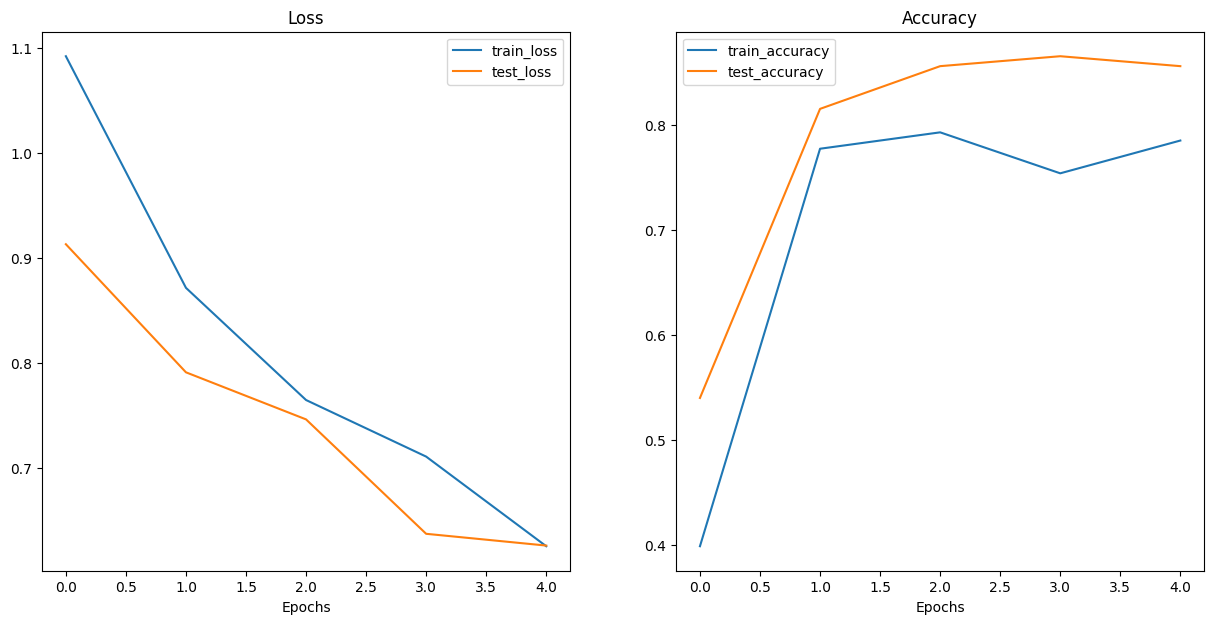

In [ ]:
##Evaluate model by plotting loss curves

try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading")
  with open("helper_functions.py","wb") as f:
    import requests
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

plot_loss_curves(results)


In [ ]:
## Make predictions on images from the test set

# let's add here to the data explorer's motto of visualize..
# and make some qualitative predicitons on our test set
# some things to keep in mind when making predictions/inference on test data/custom data.

# we have to make sure that our test/custom data is:
# same shape - images need to be same shape as model was trained on
# same datatype - custom data should be in the same data type
# same device - custom data / test data should be on the same device as the model
# same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

# to do all of this automatically, let's  create a dunction callde 'pred_and_plot_image()'

# take in a trained model, a list of class names, a filepath to a target imagen an image size a transform and a target device
# open the image with PIL.Image.Open()
# Create a transform if one doesn't exist
# make sure the model is on the target device
# turn the model to model.eval() mode to make sure it's ready for inference
# transform the target image and make sure its dimensionality is suited for the model
# make a prediction on the image by passing to the model
# conver the model's output logits to prediction probabilities using torch.softmax
# convert model's prediction probabilities to prediciton labels using torch.argmax
# plot the image with matplotlib and set the title to the prediction label from step 9 and prediction probability from step 8


In [ ]:
from typing import List,Tuple
from PIL import Image
from torchvision import transforms

# take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int,int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  #open the image
  img = Image.open(image_path)

  #Create a transform
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ])

  ## Predict on image
  # make sure the model is on the target device
  model.to(device)

  # turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    #transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0)
    ## make prediction
    target_image_pred = model(transformed_image.to(device))

  # convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred,dim=1)
  print(target_image_pred_probs.max())
  # convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs,dim=1)
  #plot image
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)

tensor(0.7304, device='cuda:0')
tensor(0.4659, device='cuda:0')
tensor(0.5739, device='cuda:0')


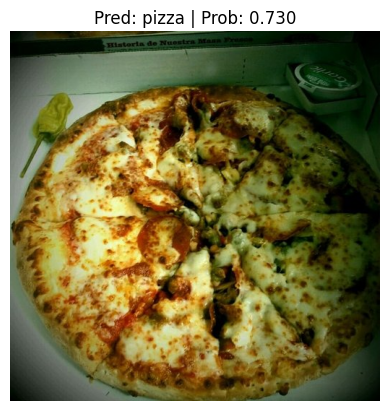

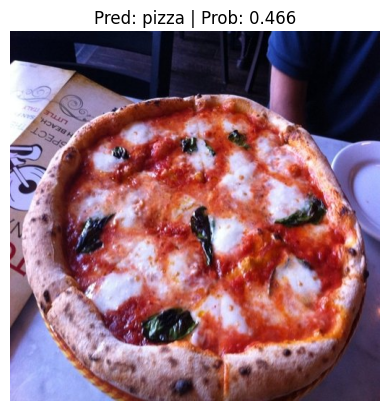

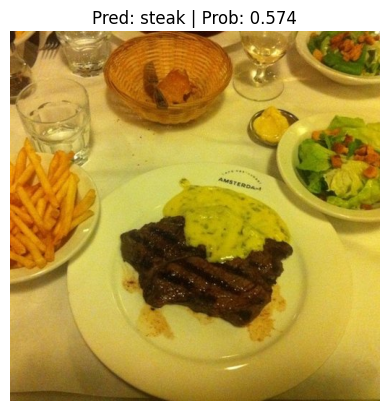

In [ ]:
# get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)
#test_image_path_sample
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))

In [ ]:
# making predictions on a custom image

custom_image_path = data_path/"04-pizza-dad.jpeg"
if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true")
    print(f"Downloading....")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

Downloading....


tensor(0.4988, device='cuda:0')


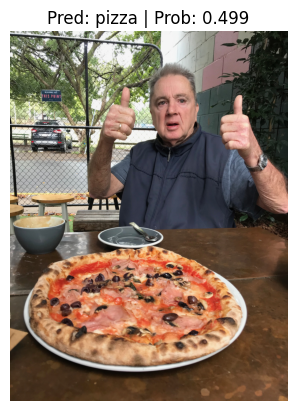

In [ ]:
pred_and_plot_image(model,custom_image_path,class_names)